# Final Project: Task 2 - Biodiversity Intactness Index Change in Phoenix, AZ

# **About**

**Purpose:** Analyze the effects of urban expansion on biodiversity in Phoenix, Arizona.

**GitHub Link**

[https://github.com/zachyyy700/eds220-phoenix-biodiversity]()

**Highlights:**

- `rioxarray` raster operations
- Spatiotemporal Asset Catalog (`STAC`) data search
- Microsoft Planetary Computer (MPC) STAC API interaction

**Data:** 
- Biodiversity Intactness Index (BII) Time Series: From the io-biodiversity collection from the Microsoft Planetary Computer STAC. For data access, follow API interaction steps listed under "Example Notebook" at [https://planetarycomputer.microsoft.com/dataset/io-biodiversity#overview]().
- Arizona Shapefiles: From the Arizona counties polygon provided by the US Census Bureau. Data accessed through downloading the .zip file from [https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision]().

**References**

F. Gassert, J. Mazzarello, and S. Hyde, “Global 100m Projections of Biodiversity Intactness for the years 2017-2020 [Technical Whitepaper].” Aug. 2022. Available: [https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf]()

U.S. Census Bureau. (2024). TIGER/Line Shapefile, Current, State, Arizona, County Subdivision. Retrieved from [https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision]()

# Analysis

## Load packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import planetary_computer
from pystac_client import Client
import contextily as ctx
from matplotlib.lines import Line2D

## Load and explore county data

In [2]:
# Read Arizona shapefile
path = os.path.join('data', 'tl_2024_04_cousub', 'tl_2024_04_cousub.shp')
arizona = gpd.read_file(path)

In [3]:
arizona.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   80 non-null     object  
 1   COUNTYFP  80 non-null     object  
 2   COUSUBFP  80 non-null     object  
 3   COUSUBNS  80 non-null     object  
 4   GEOID     80 non-null     object  
 5   GEOIDFQ   80 non-null     object  
 6   NAME      80 non-null     object  
 7   NAMELSAD  80 non-null     object  
 8   LSAD      80 non-null     object  
 9   CLASSFP   80 non-null     object  
 10  MTFCC     80 non-null     object  
 11  FUNCSTAT  80 non-null     object  
 12  ALAND     80 non-null     int64   
 13  AWATER    80 non-null     int64   
 14  INTPTLAT  80 non-null     object  
 15  INTPTLON  80 non-null     object  
 16  geometry  80 non-null     geometry
dtypes: geometry(1), int64(2), object(14)
memory usage: 10.8+ KB


In [4]:
# Display crs
arizona.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [5]:
arizona['NAME'].unique()

array(['Flagstaff', 'Kaibab Plateau', 'Hualapai', 'Nogales', 'Patagonia',
       'Hopi', 'Tuba City', 'Clifton', 'Duncan', 'Chandler', 'Phoenix',
       'Tonto National Forest', 'Gila Bend', 'Wickenburg', 'Deer Valley',
       'Buckeye', 'St. Johns', 'Salt River', 'Tucson', 'Arivaca',
       'Indian Wells', 'Winslow-Holbrook', 'Snowflake', 'Kayenta',
       'Lake Havasu City', 'Fort Apache', 'Bisbee', 'Bowie', 'Willcox',
       'North Mohave', 'Kingman', 'Bullhead City', 'Congress',
       'Mingus Mountain', 'Florence', 'North Pinal', 'San Manuel', 'Eloy',
       'Chinle', 'Sweetwater', 'Fort Defiance', 'Dennehotso', 'Puerco',
       'Ash Fork', 'Cordes Lakes-Mayer', 'Camp Verde-Sedona', 'Prescott',
       'Piñon', 'Payson', 'Winkelman', 'Globe-Miami', 'Tonto Basin',
       'Gila River', 'Casa Grande', 'Maricopa-Stanfield',
       "Tohono O'odham Nation", 'Coolidge', 'Ajo', 'Marana', 'Somerton',
       'Bonita-Klondyke', 'Eagar-Springerville', 'San Carlos',
       'Havasupai', 'William

In [6]:
# Filter to only Phoenix geometry
phoenix = arizona[arizona['NAME'] == "Phoenix"]

<Axes: >

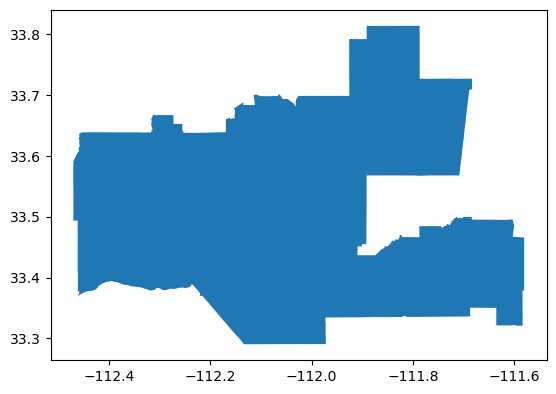

In [7]:
#
phoenix.plot()

**Arizona County Data Exploration:**

With `.info()`, a brief overview of the column names, non-null counts, and data types are displayed. Next, the GeoDataFrame's Coordinate Reference System (CRS) was displayed and was a geographic CRS - "EPSG:4269". Exploring the 'NAME' column, 'Phoenix', our area of interest is confirmed to exist in the GeoDataFrame and it is filtered to only that row where `'NAME' == "Phoenix"`.

## Access and explore BII data

To load the BII data, parameters can be set like `bbox` and `dates` which is passed in the `.search()` method. This will narrow our search within the STAC API so we only receive data of specified interest.

In [8]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Set search parameters
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]
dates = "2017-01-01/2021-01-01"

# Search MPC catalog
search = catalog.search(collections=["io-biodiversity"], bbox=bbox, datetime=dates)
items = search.item_collection()

In [9]:
# Print the datatimes of received items
for item in items:
    print(item.properties['start_datetime'])

2020-01-01T00:00:00Z
2019-01-01T00:00:00Z
2018-01-01T00:00:00Z
2017-01-01T00:00:00Z


In [10]:
# Load the items data into DataArrays
biodiv_2017 = rioxr.open_rasterio(items[3].assets["data"].href)
biodiv_2020 = rioxr.open_rasterio(items[0].assets["data"].href)

In [11]:
print(f"Current CRS:\n{biodiv_2017.spatial_ref.crs_wkt}\n")
print(f"Data Bounds:\n{biodiv_2017.rio.bounds()}")

Current CRS:
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]

Data Bounds:
(-115.38597824385106, 27.56531399453427, -108.20664249316783, 34.74464974521749)


**BII Data Exploration:**

After searching the catalog, we received four items in the `items` object and each of these items contain data for our dates of interest. Additionally, the dates of interest were confirmed to be the first day of the year from 2017 - 2020. After loading the 2017 & 2020 data into DataArray's with `rioxr`, the CRS was found to also be geographic but as "EPSG:4326". The bounds of the DataArrays were also printed.

Before further analysis, the CRS must match for each of these geospatial data. Since there are two BII rasters, let's change the Phoenix CRS to match the BII data CRS.

In [14]:
# Print CRS mismatch
print(biodiv_2017.rio.crs)
print(phoenix.crs)

EPSG:4326
EPSG:4269


In [15]:
# Change Phoenix CRS to match
phoenix = phoenix.to_crs("EPSG:4326")
assert phoenix.crs == biodiv_2017.rio.crs

## Phoenix subdivision

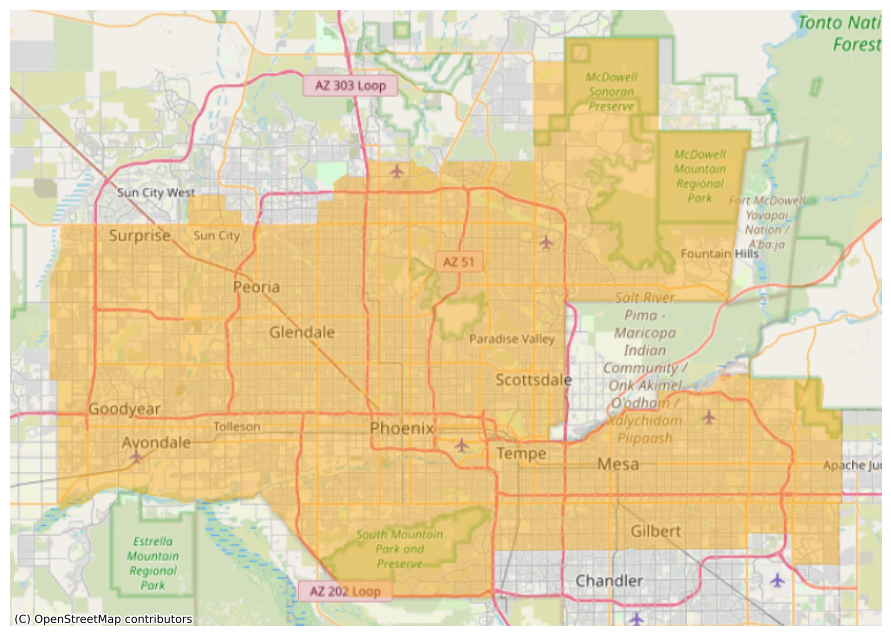

In [16]:
fig, ax = plt.subplots(figsize=(15, 8))

phoenix.plot(ax=ax, alpha=0.4, color='orange')

ax.axis('off')

# Add basemap using contextily
ctx.add_basemap(ax, crs=phoenix.crs, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()

In [17]:
# Clip biodiversity data to Phoenix total bounds, then to the subdivision geometry
biodiv_2017_clip = biodiv_2017.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry)
biodiv_2020_clip = biodiv_2020.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry)

## BII Percentage Comparison

To calculate high BII percentages, we can use a boolean operation to assign high BII cells to `True` and then sum the `True` values. Dividing this number by the total amount of cells and multiplying by 100, the percentage of high BII for both years are found.

In [18]:
# Calculate percentages of high BII for 2017 & 2020
high_bii_2017 = biodiv_2017_clip >= 0.75
pct_2017 = (high_bii_2017.sum() / biodiv_2017_clip.count()) * 100

high_bii_2020 = biodiv_2020_clip >= 0.75
pct_2020 = (high_bii_2020.sum() / biodiv_2020_clip.count()) * 100

print(f"High BII Percentage in 2017: {pct_2017.values:.2f}%")
print(f"High BII Percentage in 2020: {pct_2020.values:.2f}%")

High BII Percentage in 2017: 7.13%
High BII Percentage in 2020: 6.49%


## Visualize BII Change

Create a visualization showing the area with BII>=0.75 in 2017 that was lost by 2020.

- Right now in high_bii_2017 & high_bii_2020 arrays, cells are `True` if BII >= 0.75.
- We want cells where high_bii_2017 == `True` *and* high_bii_2020 == `False`
- Using `~` on `high_bii_2020`, boolean values are inverted
- Combined with the `&` operator, the resulting DataArray is True where cells meet both conditions, indicating a drop in BII from 2017 to 2020

`xr.DataArray.where()`

- Returns elements from ‘DataArray’, where ‘cond’ is True, otherwise fill in ‘other’ (NA by default).

In [19]:
bii_loss = high_bii_2017 & (~high_bii_2020)

# Assign 0 to nan
bii_loss_masked = bii_loss.where(bii_loss != 0)

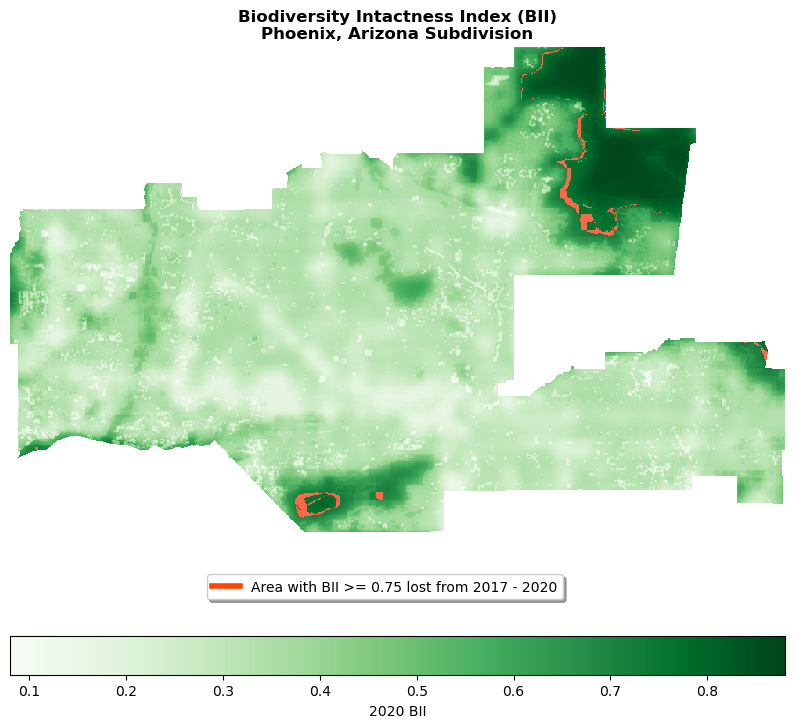

In [20]:
fig, ax = plt.subplots(figsize=(10, 9)) 

ax.axis('off')

biodiv_2020_clip.plot(ax=ax, cmap="Greens", cbar_kwargs={'location':'bottom', 'label':'2020 BII'})
bii_loss_masked.plot(ax=ax, cmap='Reds', 
                     add_colorbar=False)

# Custom legend
custom_line = [Line2D([0], [0], color='orangered', lw=4)]
fig.legend(custom_line, ['Area with BII >= 0.75 lost from 2017 - 2020'], bbox_to_anchor=(0.5, 0.28), loc='center', fontsize=10, shadow=True)

plt.title("Biodiversity Intactness Index (BII)\nPhoenix, Arizona Subdivision", weight='bold')
plt.show()

In this final plot, 2020 BII values of the Phoenix area are plotted along a green color scale, where darker greens indicate higher BII. In addition, areas with high BII that were lost from 2017 to 2020 are highlighted in an orange-red color. Two notable areas are around the South Mountain Park and Reserve (bottom) and the McDowell Mountain Regional Park (top right). These are areas with high BII indicated by the dark green but they also contain significant areas of BII loss, likely due to Phoenix's urban expansion.